# 线性回归

$$
y=w_{1} x_{1}+w_{2} x_{2}+w_{3} x_{3}+b
$$

$$
y=\langle\mathbf{w}, \mathbf{x}\rangle+b
$$

- 可以视为一层神经网络
- 定义损失函数

$$
\ell(y, \hat{y})=\frac{1}{2}(y-\hat{y})^{2}
$$

- 训练数据

$$
\mathbf{X}=\left[\mathbf{x}_{1}, \mathbf{x}_{2}, \ldots, \mathbf{x}_{n}\right]^{T} \quad \mathbf{y}=\left[y_{1}, y_{2}, \ldots, y_{n}\right]^{T}
$$

- 参数学习
- 训练损失

$$
\ell(\mathbf{X}, \mathbf{y}, \mathbf{w}, b)=\frac{1}{2 n} \sum_{i=1}^{n}\left(y_{i}-\left\langle\mathbf{x}_{i}, \mathbf{w}\right\rangle-b\right)^{2}=\frac{1}{2 n}\|\mathbf{y}-\mathbf{X} \mathbf{w}-b\|^{2}
$$

- 最小化损失

$$
\mathbf{w}^{*}, \mathbf{b}^{*}=\arg \min _{\mathbf{w}, b} \ell(\mathbf{X}, \mathbf{y}, \mathbf{w}, b)
$$

- 线性回归解析解
- 将偏差加入权重

$$
\mathbf{X} \leftarrow[\mathbf{X}, \mathbf{1}] \quad \mathbf{w} \leftarrow\left[\begin{array}{l}
\mathbf{w} \\
b
\end{array}\right]
$$

$$
\ell(\mathbf{X}, \mathbf{y}, \mathbf{w})=\frac{1}{2 n}\|\mathbf{y}-\mathbf{X w}\|^{2} \frac{\partial}{\partial \mathbf{w}} \ell(\mathbf{X}, \mathbf{y}, \mathbf{w})=\frac{1}{n}(\mathbf{y}-\mathbf{X w})^{T} \mathbf{X}
$$

- 损失是凸函数，最优解为梯度为零处

$$
\begin{aligned}
& \frac{\partial}{\partial \mathbf{w}} \ell(\mathbf{X}, \mathbf{y}, \mathbf{w})=0 \\
\Leftrightarrow & \frac{1}{n}(\mathbf{y}-\mathbf{X} \mathbf{w})^{T} \mathbf{X}=0 \\
\Leftrightarrow & \mathbf{w}^{*}=\left(\mathbf{X}^{T} \mathbf{X}_{}\right)^{-1} \mathbf{X} \mathbf{y}
\end{aligned}
$$


# 基础优化算法

- 选择一个初始值 $\text{w}_0$
- 重复迭代

$$
\mathbf{w}_{t}=\mathbf{w}_{l-1}-\eta \frac{\partial \ell}{\partial \mathbf{w}_{t-1}}
$$

- 学习率不能太大也不能太小
- 梯度下降**很贵**
- 我们可以随机采样 $b$ 个样本来接近损失

$$
\frac{1}{b} \sum_{i \in I_{b}} \ell\left(\mathbf{x}_{i}, y_{i}, \mathbf{w}\right)
$$

- $b$ 是 `batch_size`


In [1]:
import random
import torch
from d2l import torch as d2l

In [2]:
def synthetic_data(w, b, num_examples):
    # generate y = w * x + b + random_noise
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print("features ->", features[0])
print("label ->", labels[0])

features -> tensor([0.5766, 0.2599])
label -> tensor([4.4599])


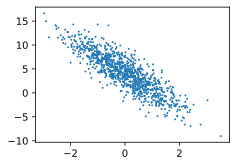

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, "\n", y)
    break

tensor([[ 0.0282,  0.0594],
        [ 0.0413, -1.0200],
        [ 0.0906,  0.2369],
        [-0.1521,  0.6741],
        [-1.3748, -0.8807],
        [-1.0469, -0.3552],
        [ 0.8700, -0.1220],
        [-0.1743,  0.1272],
        [-0.5441, -1.9610],
        [ 0.3554,  1.4201]]) 
 tensor([[4.0419],
        [7.7532],
        [3.5878],
        [1.6049],
        [4.4368],
        [3.3082],
        [6.3586],
        [3.4323],
        [9.7721],
        [0.0953]])


In [6]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [7]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [8]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [9]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [10]:
lr = 0.001
num_epochs = 100
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f"====================> epoch {epoch + 1}, loss {float(train_l.mean()):f}")

====================> epoch 1, loss 13.426624
====================> epoch 2, loss 11.022688
====================> epoch 3, loss 9.049136
====================> epoch 4, loss 7.428981
====================> epoch 5, loss 6.098902
====================> epoch 6, loss 5.006967
====================> epoch 7, loss 4.110518
====================> epoch 8, loss 3.374589
====================> epoch 9, loss 2.770430
====================> epoch 10, loss 2.274436
====================> epoch 11, loss 1.867244
====================> epoch 12, loss 1.532954
====================> epoch 13, loss 1.258518
====================> epoch 14, loss 1.033218
====================> epoch 15, loss 0.848254
====================> epoch 16, loss 0.696403
====================> epoch 17, loss 0.571736
====================> epoch 18, loss 0.469389
====================> epoch 19, loss 0.385366
====================> epoch 20, loss 0.316385
====================> epoch 21, loss 0.259754
====================> epoch 22, loss 0.21

In [11]:
print("w ->", true_w - w.reshape(true_w.shape))
print("b ->", true_b - b)

w -> tensor([1.4746e-04, 6.3181e-05], grad_fn=<SubBackward0>)
b -> tensor([0.0003], grad_fn=<RsubBackward1>)


In [22]:
import random
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [23]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[ 0.1512,  0.1103],
         [-0.8960, -0.3709],
         [ 1.4361,  1.9263],
         [ 1.3825, -0.0550],
         [ 0.6749, -1.6813],
         [-0.0714,  2.0462],
         [ 1.6199, -0.6324],
         [ 0.5149, -1.0860],
         [-1.3980, -1.3839],
         [-1.1703,  1.3383]]),
 tensor([[ 4.1267],
         [ 3.6810],
         [ 0.5316],
         [ 7.1610],
         [11.2546],
         [-2.9072],
         [ 9.5991],
         [ 8.9135],
         [ 6.0952],
         [-2.6943]])]

In [24]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [25]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [26]:
loss = nn.MSELoss()

In [27]:
trainer = torch.optim.SGD(net.parameters(), lr = 0.001)

In [28]:
num_epochs = 60
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f"====================> epoch {epoch + 1}, loss {l:f}")

====================> epoch 1, loss 22.353918
====================> epoch 2, loss 14.925794
====================> epoch 3, loss 9.966902
====================> epoch 4, loss 6.656296
====================> epoch 5, loss 4.445819
====================> epoch 6, loss 2.969691
====================> epoch 7, loss 1.983870
====================> epoch 8, loss 1.325444
====================> epoch 9, loss 0.885631
====================> epoch 10, loss 0.591821
====================> epoch 11, loss 0.395532
====================> epoch 12, loss 0.264383
====================> epoch 13, loss 0.176746
====================> epoch 14, loss 0.118184
====================> epoch 15, loss 0.079048
====================> epoch 16, loss 0.052883
====================> epoch 17, loss 0.035396
====================> epoch 18, loss 0.023703
====================> epoch 19, loss 0.015886
====================> epoch 20, loss 0.010661
====================> epoch 21, loss 0.007167
====================> epoch 22, loss 0.00